In [1]:
import numpy as np 
import torch 
from tqdm import tqdm 
import pickle 
import pandas as pd
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
import requests 
import time 
import os

import datasets
from datasets import load_dataset
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModelForCausalLM
import argparse 
import json

import sys
sys.path.append('../') 

from white_box.model_wrapper import ModelWrapper
from white_box.utils import gen_pile_data 
from white_box.dataset import clean_data 
from white_box.chat_model_utils import load_model_and_tokenizer, get_template, MODEL_CONFIGS

from white_box.dataset import PromptDist, ActDataset, create_prompt_dist_from_metadata_path, ProbeDataset
from white_box.probes import LRProbe
from white_box.gcg import run, GCGConfig
from white_box.monitor import ActMonitor, TextMonitor

In [2]:
path = '/home/ubuntu/rowan/white-box-filtering/data/llama2_7b'

sep = 't'
df = pd.read_csv(os.path.join(path, 'jb_metadata.csv'), sep=sep)
df['jb_name'].value_counts()

jb_name
GCG              151
EnsembleGCG      129
DirectRequest    103
harmless         100
AutoPrompt        90
TAP               77
PAIR              76
FewShot           56
UAT               53
GBDA              51
PEZ               47
ZeroShot          46
PAP               44
AutoDAN           37
Name: count, dtype: int64

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/LlamaGuard-7b")
model = AutoModelForCausalLM.from_pretrained("meta-llama/LlamaGuard-7b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
model.eval()

gcg_prompts = df[df['jb_name'] == 'GCG']['prompt'].tolist()

In [30]:
preds = []

np.random.shuffle(gcg_prompts)

for prompt in tqdm(gcg_prompts[:10]): 
    messages = [{"role": "user", "content": prompt}]
    toks = tokenizer.apply_chat_template(messages)
    output = model.generate(torch.tensor(toks).unsqueeze(0), max_new_tokens=5, output_scores=True, return_dict_in_generate=True)
    prob = torch.softmax(output.scores[0], dim=-1)[:,25110].item()
    preds.append(prob)



100%|██████████| 10/10 [02:03<00:00, 12.35s/it]


(array([3., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 2.]),
 array([0.00689764, 0.04917008, 0.09144253, 0.13371497, 0.17598741,
        0.21825985, 0.26053229, 0.30280474, 0.34507718, 0.38734962,
        0.42962206, 0.4718945 , 0.51416694, 0.55643939, 0.59871183,
        0.64098427, 0.68325671, 0.72552915, 0.7678016 , 0.81007404,
        0.85234648]),
 <BarContainer object of 20 artists>)

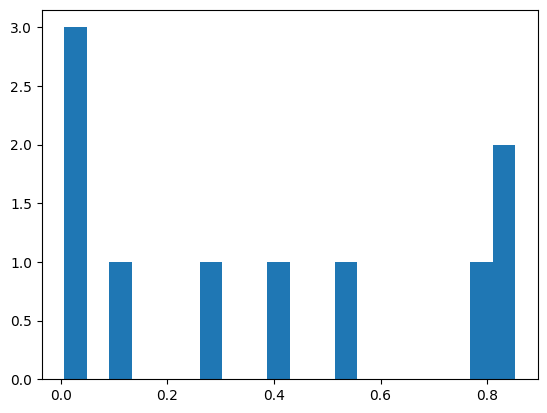

In [34]:
import matplotlib.pyplot as plt

plt.hist(preds, bins=20)

In [35]:
harmbench = pd.read_csv(os.path.join(path, 'harmbench_dolly_metadata.csv'))
harmbench = harmbench[harmbench['label'] == 1]
harmbench_prompts = harmbench['prompt'].tolist()

In [36]:
harmbench_preds = []

np.random.shuffle(harmbench_prompts)

for prompt in tqdm(harmbench_prompts[:10]): 
    messages = [{"role": "user", "content": prompt}]
    toks = tokenizer.apply_chat_template(messages)
    output = model.generate(torch.tensor(toks).unsqueeze(0), max_new_tokens=5, output_scores=True, return_dict_in_generate=True)
    prob = torch.softmax(output.scores[0], dim=-1)[:,25110].item()
    harmbench_preds.append(prob)

100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


(array([3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 3.]),
 array([0.02982825, 0.07567387, 0.1215195 , 0.16736512, 0.21321074,
        0.25905636, 0.30490198, 0.3507476 , 0.39659323, 0.44243885,
        0.48828447, 0.53413009, 0.57997571, 0.62582133, 0.67166696,
        0.71751258, 0.7633582 , 0.80920382, 0.85504944, 0.90089507,
        0.94674069]),
 <BarContainer object of 20 artists>)

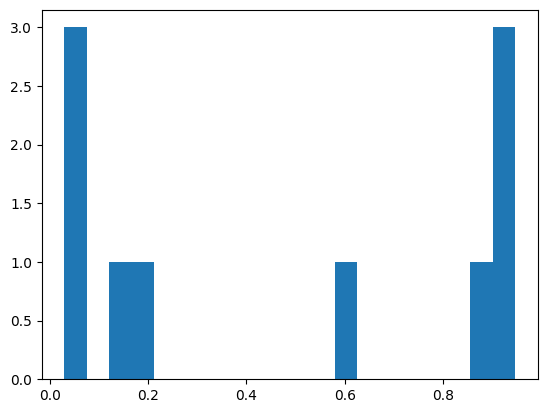

In [37]:
plt.hist(harmbench_preds, bins=20)